# Deep Convolutional GAN (DCGAN) 

Generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.constraints import MinMaxNorm

In [2]:
utils.disable_interactive_logging()

In [3]:
# Load MNIST dataset
def load_mnist():
    (X_train, _), (_, _) = mnist.load_data()
    # Normalize data to range [-1, 1]
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    # Flatten images
    X_train = X_train.reshape(-1, 28*28)
    return X_train

In [4]:
# Build generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(784, activation='tanh'))
    return model

# Build discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile discriminator model
def compile_discriminator(model):
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Compile combined model (generator + discriminator)
def compile_combined(generator, discriminator):
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

# Function to display generated images
def display_generated_images(generator, latent_dim, num_samples=10, epoch=None):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images * 0.5 + 0.5  # Rescale images to [0, 1]
    generated_images = generated_images.reshape(-1, 28, 28)
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if epoch is not None:
        plt.suptitle(f'Generated Images at Epoch {epoch}', fontsize=16)
    plt.show()

In [5]:
# Train GAN
def train_gan(generator, discriminator, combined, X_train, latent_dim, num_epochs, batch_size,display_interval=1000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    d_losses, g_losses = [], []
    
    for epoch in range(num_epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        #discriminator loss
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined.train_on_batch(noise, real)
        
        # Store loss values
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # Print progress
        if epoch % display_interval == 0:
            print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")
            display_generated_images(generator, latent_dim, epoch=epoch)

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('GAN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 0, Discriminator Loss: 0.6534497439861298, Generator Loss: 0.6643683910369873


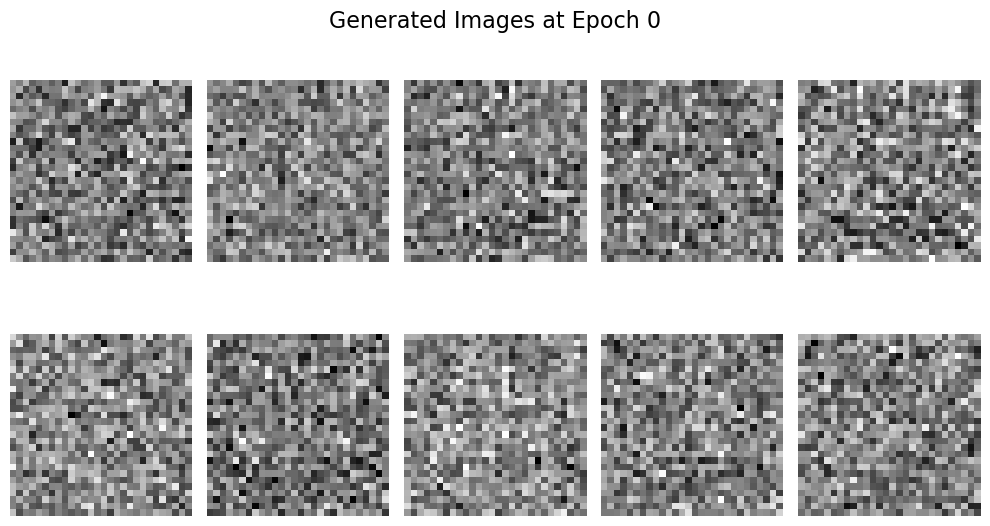

Epoch 1000, Discriminator Loss: 0.5349702686071396, Generator Loss: 0.9858880639076233


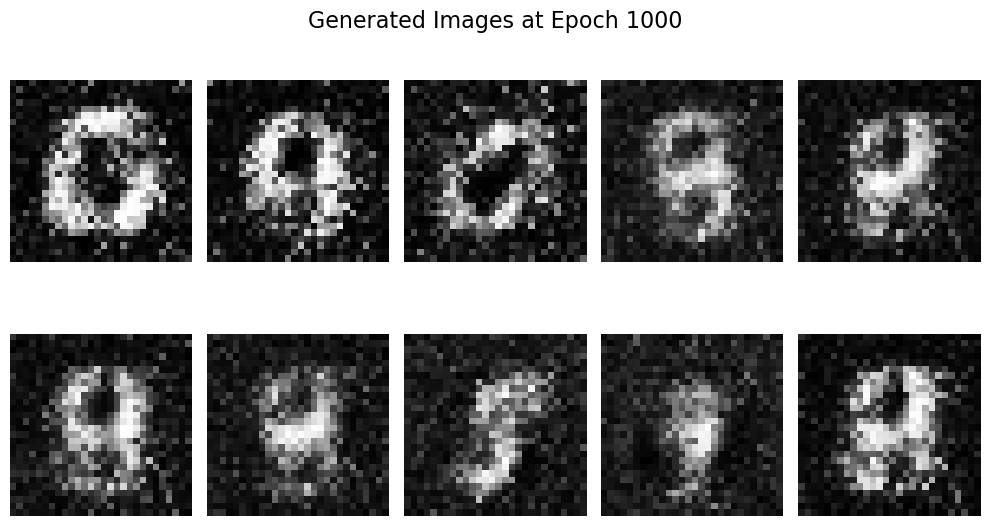

Epoch 2000, Discriminator Loss: 0.5458482205867767, Generator Loss: 1.2440755367279053


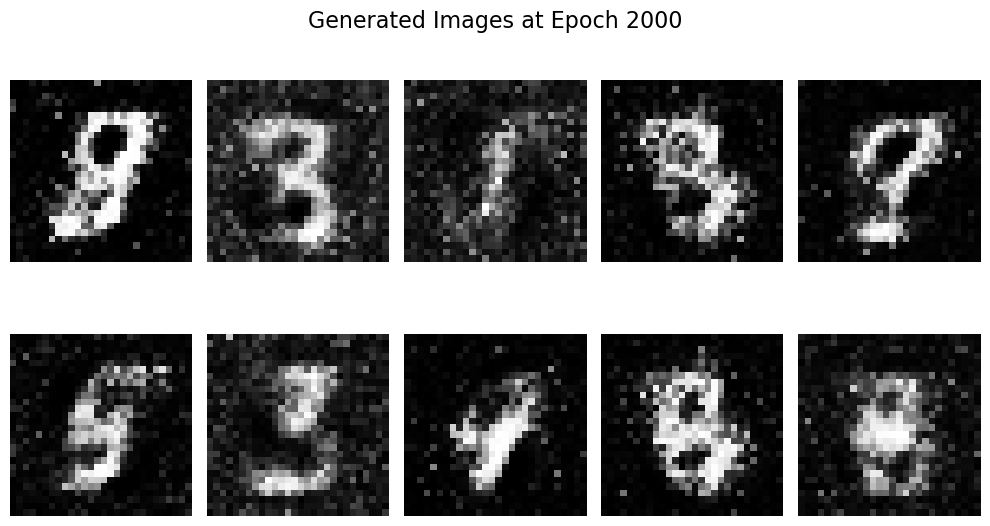

Epoch 3000, Discriminator Loss: 0.5655007362365723, Generator Loss: 1.1257718801498413


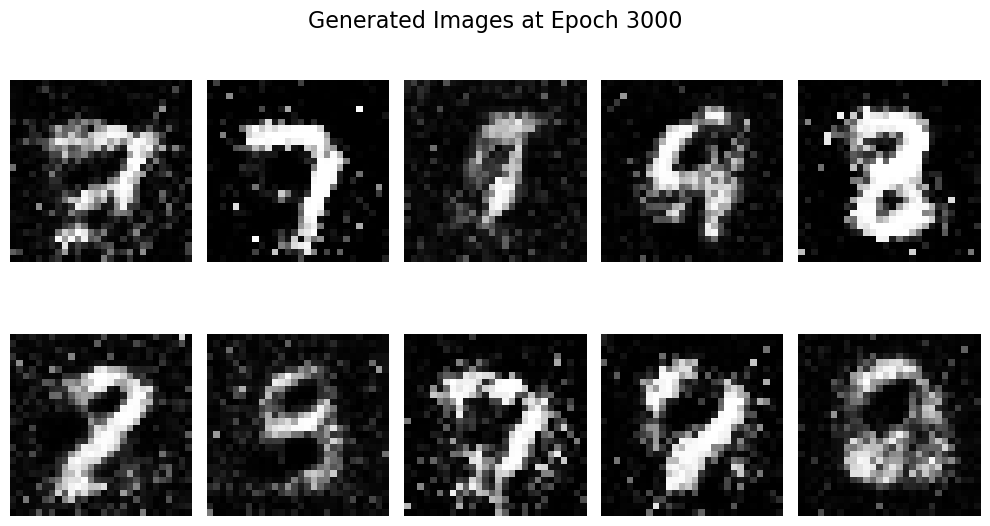

Epoch 4000, Discriminator Loss: 0.5882238745689392, Generator Loss: 1.013529896736145


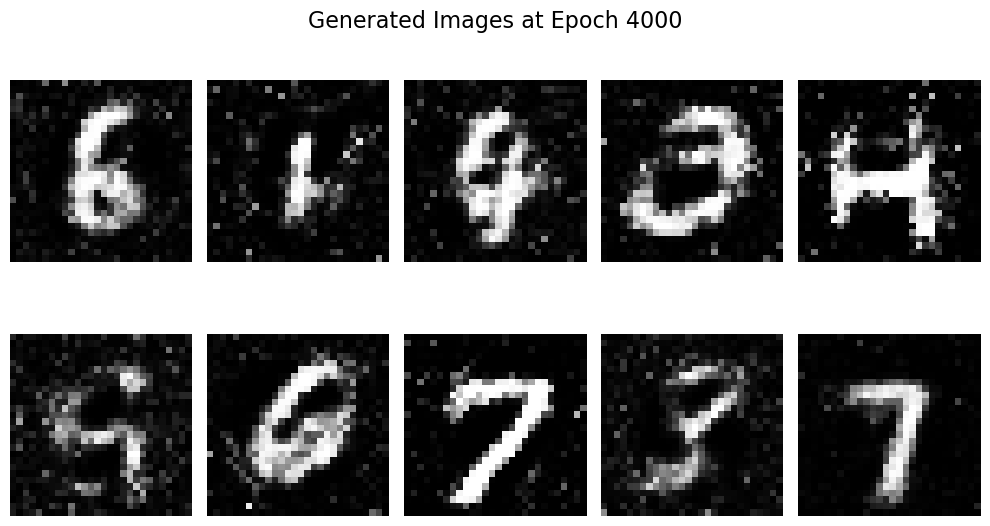

Epoch 5000, Discriminator Loss: 0.5996176600456238, Generator Loss: 0.9812296628952026


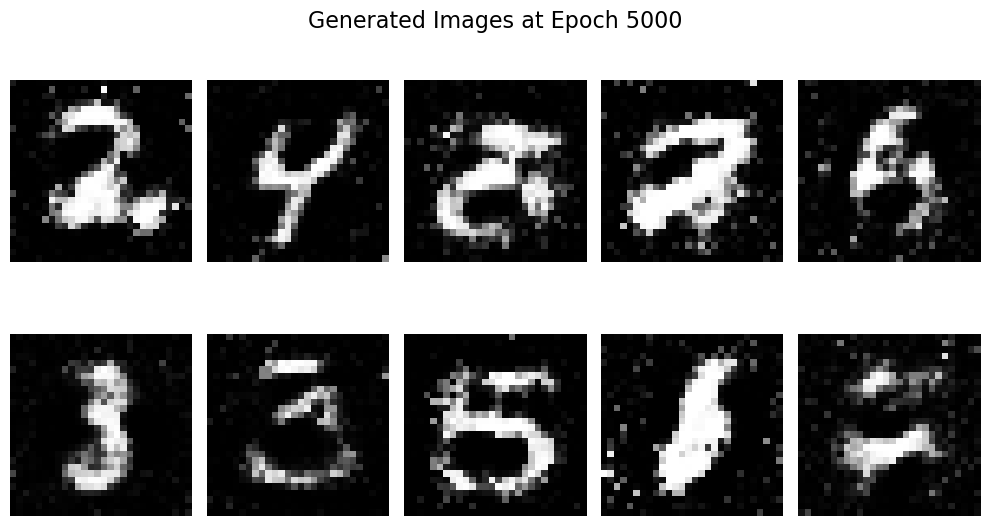

Epoch 6000, Discriminator Loss: 0.5931374132633209, Generator Loss: 0.976708173751831


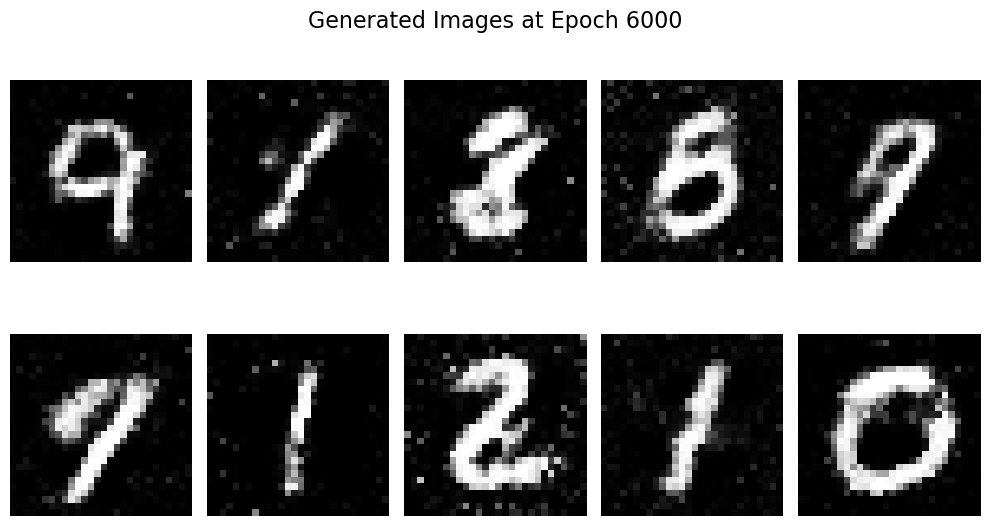

Epoch 7000, Discriminator Loss: 0.5958468914031982, Generator Loss: 0.9139745235443115


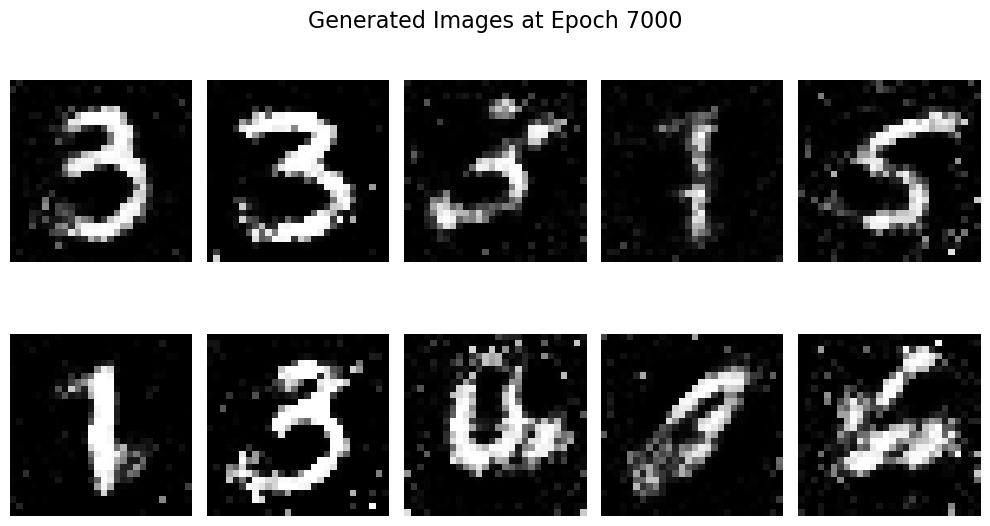

Epoch 8000, Discriminator Loss: 0.643934816122055, Generator Loss: 0.9208666086196899


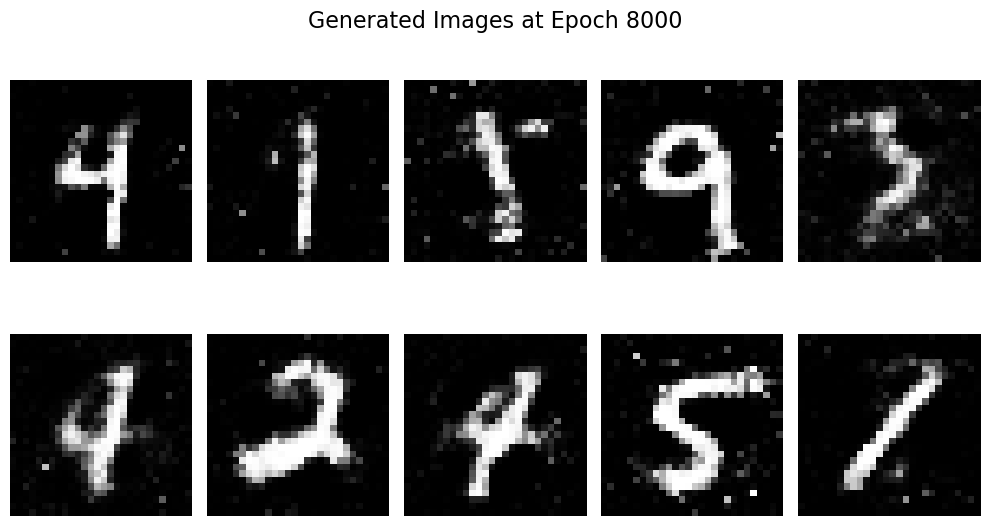

Epoch 9000, Discriminator Loss: 0.6356894671916962, Generator Loss: 0.9952078461647034


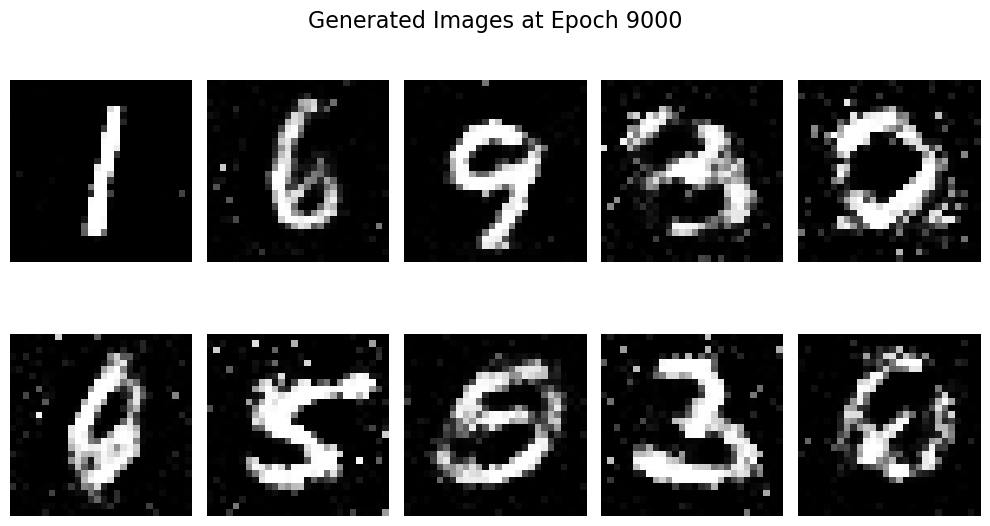

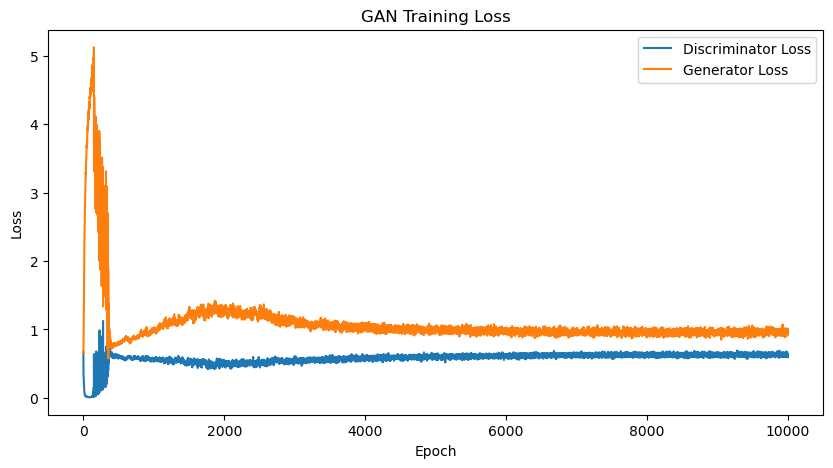

In [6]:
# Parameters
latent_dim = 100
num_epochs = 10000
batch_size = 128

# Load MNIST dataset
X_train = load_mnist()

# Build and compile discriminator model
discriminator = build_discriminator()
discriminator = compile_discriminator(discriminator)

# Build generator model
generator = build_generator(latent_dim)

# Build and compile combined model (GAN)
combined = compile_combined(generator, discriminator)
combined.summary()

# Train GAN
train_gan(generator, discriminator, combined, X_train, latent_dim, num_epochs, batch_size)

### Issues with GAN
    
    Sensitivity of loss metrics: Loss metrics like binary crossentropy might not be the best indicators of model performance, especially in GANs. They can be noisy and may not always correlate well with visual quality. Therefore, improvements in sample quality may not always be accurately reflected in loss values.

    Mode collapse: Even though the samples are improving visually, the loss curves may remain flat if the model is suffering from mode collapse. In mode collapse, the generator learns to produce only a limited variety of samples, ignoring the diversity of the input noise. As a result, the discriminator's job becomes easier, and the loss values may not change significantly.

    Stabilized training: It's possible that the GAN has reached a point where it has stabilized, and the loss values have plateaued. This can happen when the generator and discriminator reach an equilibrium where neither can significantly improve without the other adapting in response.

    Underlying complexity: The relationship between loss values and sample quality in GANs is complex and may not always be straightforward. There could be subtle changes in the samples that are not captured well by the loss metrics.

## W-GAN

Wasserstein Generative Adversarial Network (WGAN) tries to address some of the training stability issues and mode collapse problems associated with traditional GANs. 

#### Loss Function:  
    In traditional GANs, the discriminator outputs probabilities and uses binary crossentropy loss to measure the difference between the predicted probabilities and the true labels. In WGANs, the discriminator instead outputs a single scalar value, and the loss function used is the Wasserstein distance (also known as Earth Mover's Distance) between the distributions of real and generated samples.

#### Training Stability:
    WGANs offer improved training stability compared to traditional GANs. The Wasserstein distance is a more reliable measure of similarity between distributions compared to binary crossentropy loss. This stability often results in smoother training curves and reduces the likelihood of mode collapse.

#### Gradient Clipping:  
    WGANs typically use weight clipping or gradient penalty techniques to enforce a Lipschitz constraint on the discriminator. This constraint helps prevent the discriminator from becoming too powerful, which can destabilize the training process.

#### Meaningful Loss Values:
    In traditional GANs, the discriminator loss does not necessarily correlate with sample quality or training progress. In contrast, in WGANs, the value of the discriminator loss has a more meaningful interpretation as it directly relates to the Wasserstein distance between the distributions.

#### No Saturating Loss:
    Traditional GANs often suffer from the problem of saturating loss functions, where the discriminator loss converges to zero or infinity, causing training to stall. WGANs do not suffer from this issue because the Wasserstein distance is always well-defined and can provide meaningful gradients throughout training.

#### Evaluation Metrics:
    WGANs often perform better on evaluation metrics such as Inception Score or Frechet Inception Distance (FID) compared to traditional GANs. These metrics provide more reliable measures of sample quality and diversity.


In WGANs, weight clipping is one of the methods used to ensure that the Wasserstein distance remains well-defined and that the discriminator does not become too powerful.

In a WGAN, the discriminator is trained to output scores rather than probabilities. The discriminator loss is the difference between the mean score of fake samples and the mean score of real samples. By maximizing this difference, the discriminator learns to distinguish between real and fake samples effectively.

In a Wasserstein GAN (WGAN), the discriminator loss is typically not averaged between the real and fake samples as in traditional GANs. Instead, the discriminator is trained to maximize the difference between the average scores of real and fake samples. 

Epoch 0, Generator Loss: 0.002114897593855858


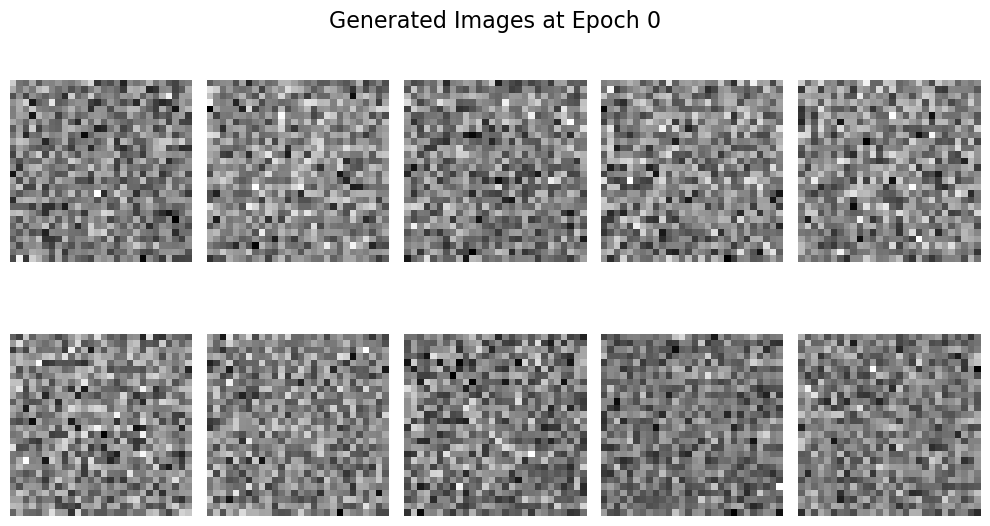

Epoch 1000, Generator Loss: 0.5093883872032166


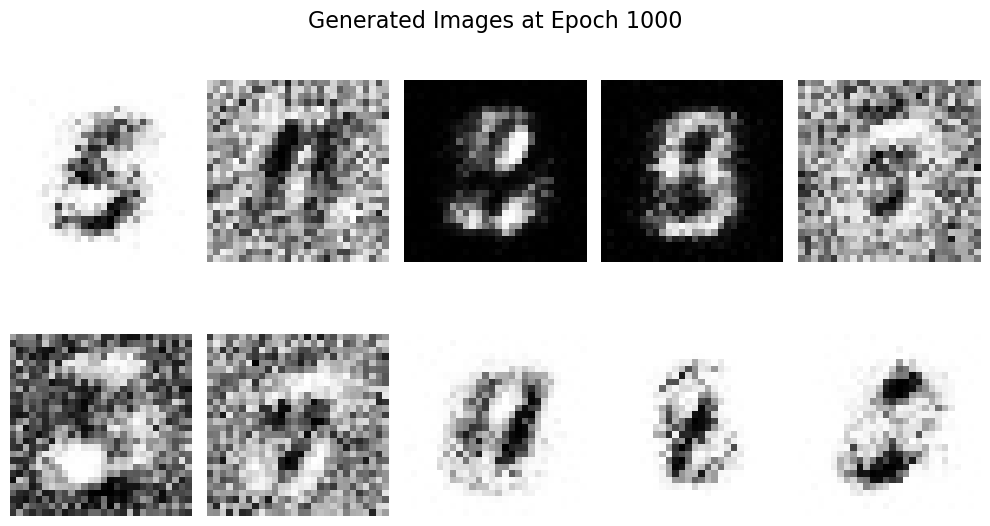

Epoch 2000, Generator Loss: 0.37811851501464844


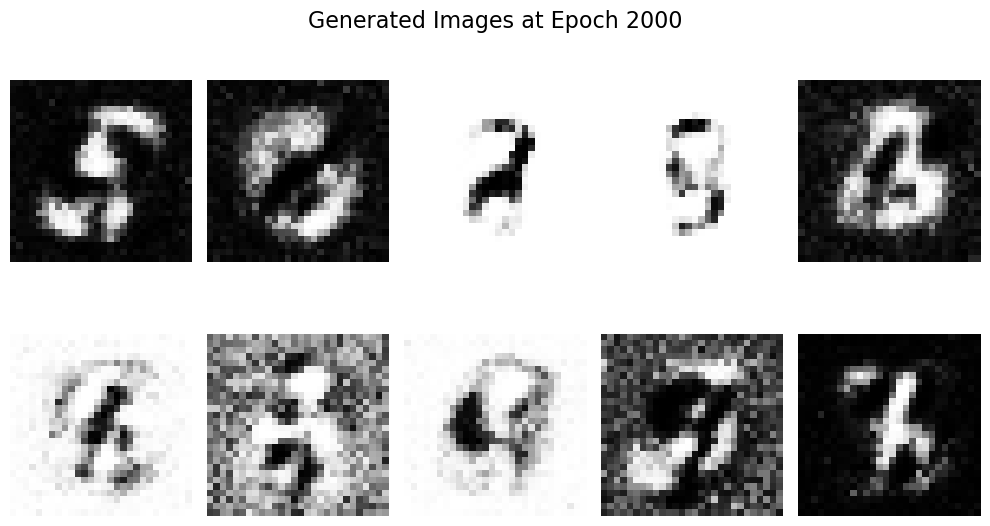

Epoch 3000, Generator Loss: 0.3476203382015228


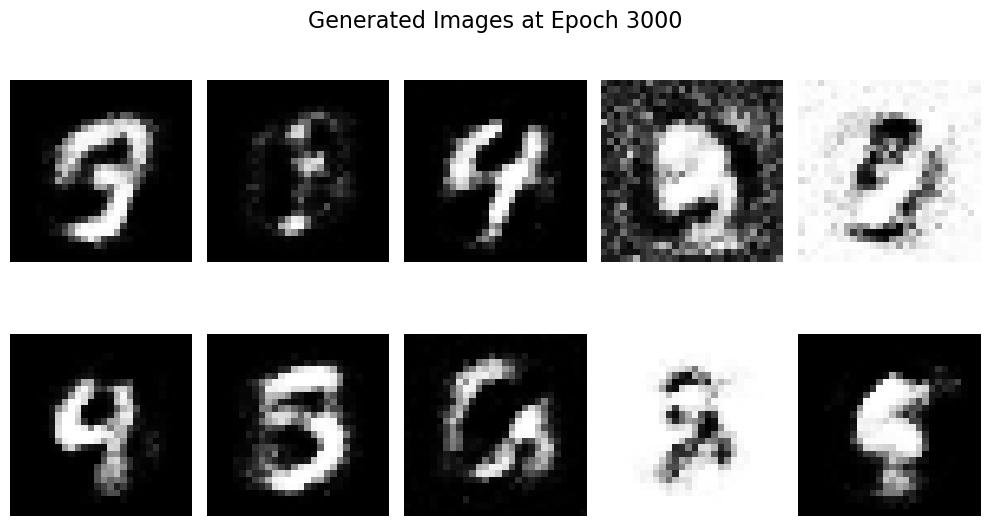

Epoch 4000, Generator Loss: 0.33166784048080444


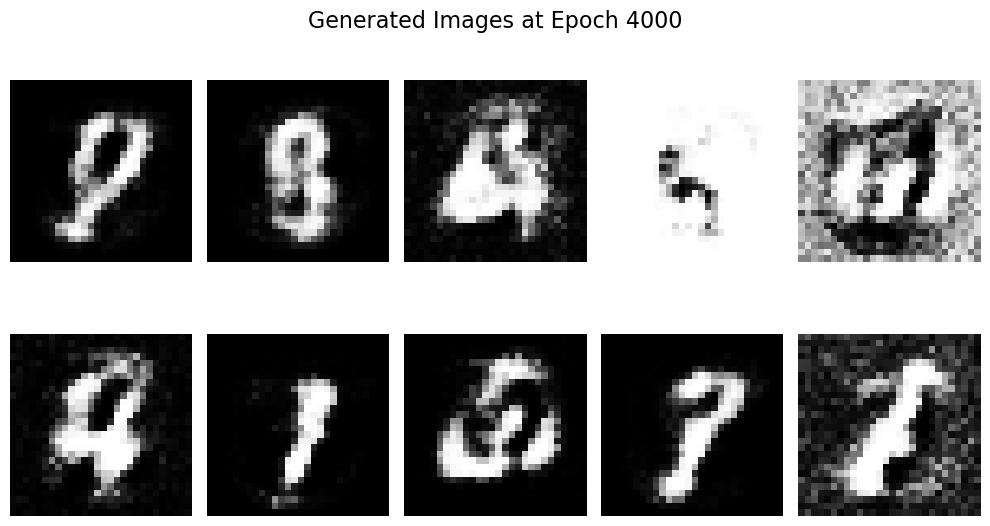

Epoch 5000, Generator Loss: 0.21614378690719604


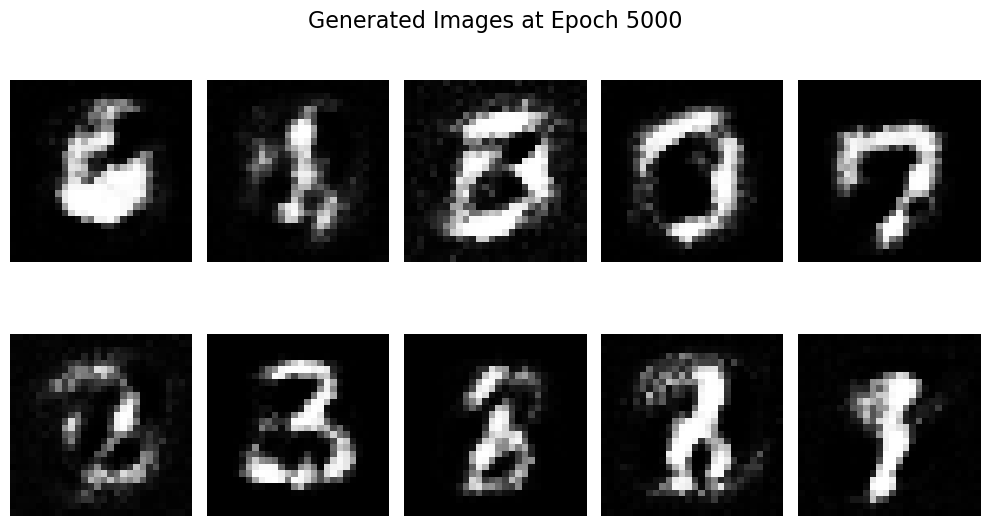

Epoch 6000, Generator Loss: 0.19491496682167053


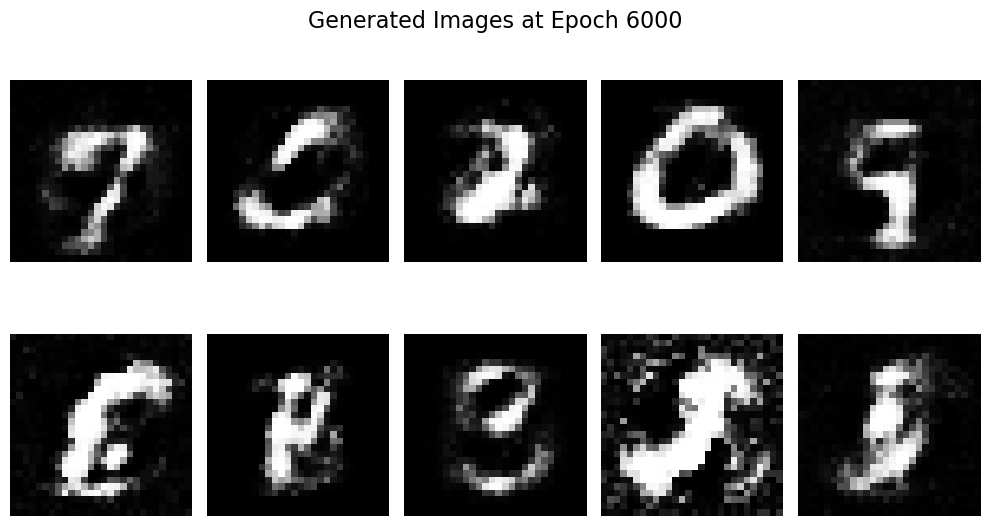

Epoch 7000, Generator Loss: 0.14534547924995422


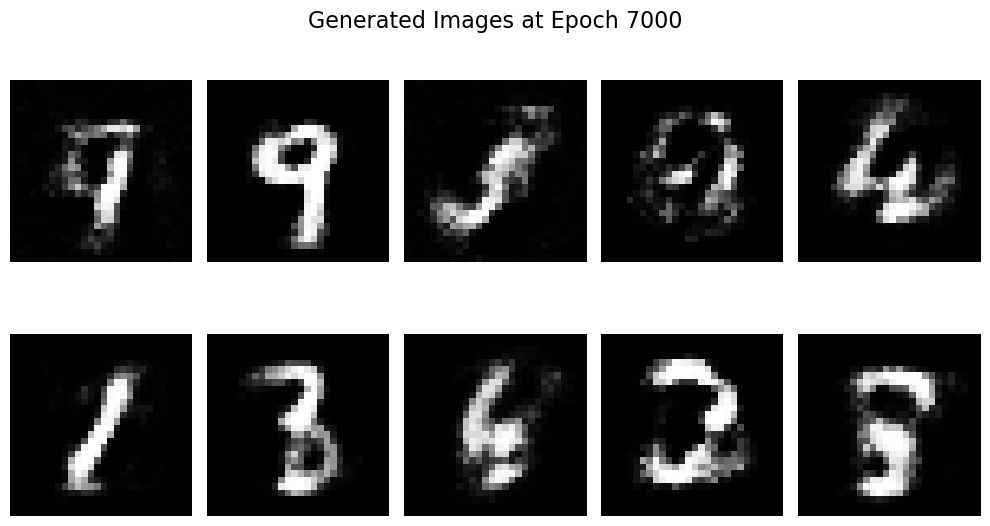

Epoch 8000, Generator Loss: 0.1548597514629364


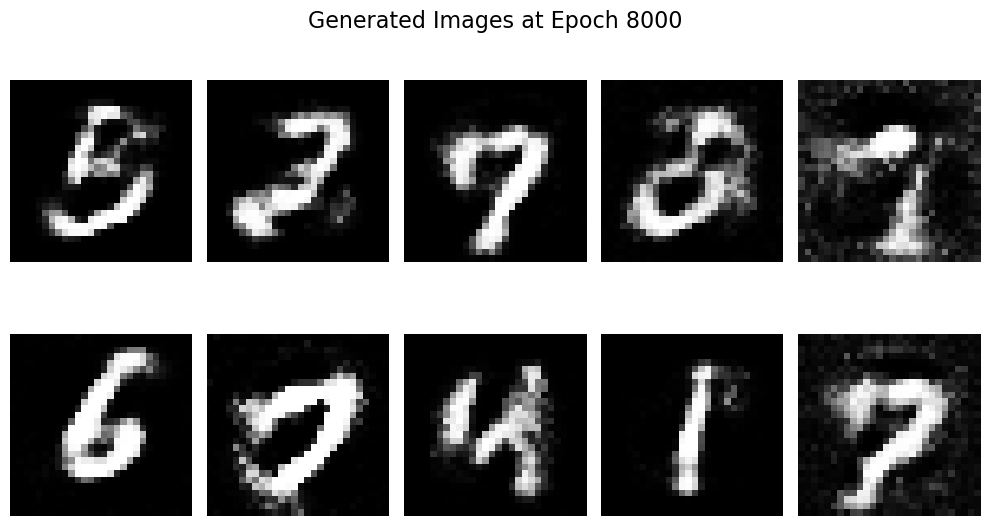

Epoch 9000, Generator Loss: 0.14051660895347595


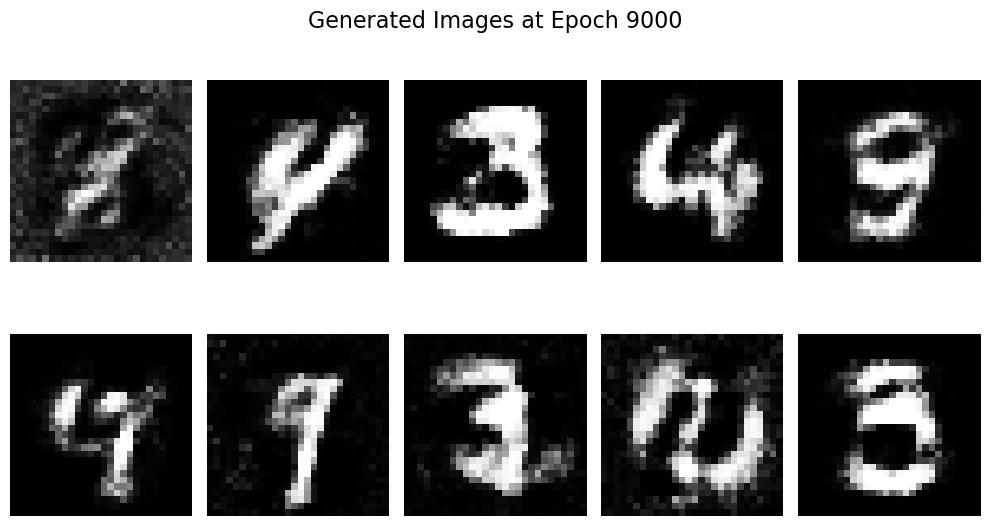

In [9]:
# Build discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=784, kernel_constraint=MinMaxNorm(min_value=-0.1, max_value=0.1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256, kernel_constraint=MinMaxNorm(min_value=-0.1, max_value=0.1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1))
    return model

# Compile discriminator model
def compile_discriminator(model):
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.00005))
    return model

# Compile combined model (generator + discriminator)
def compile_combined(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.00005))
    return model

# Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

# Train GAN
def train_gan(generator, discriminator, combined, X_train, latent_dim, num_epochs, batch_size, display_interval=1000):
    for epoch in range(num_epochs):
        # Train discriminator
        for _ in range(5): # Train discriminator more times than generator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)
            d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, -np.ones((batch_size, 1)))
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Print progress and display generated images
        if epoch % display_interval == 0:
            print(f"Epoch {epoch}, Generator Loss: {g_loss}")
            display_generated_images(generator, latent_dim, epoch=epoch)

# Build and compile discriminator model
discriminator = build_discriminator()
discriminator = compile_discriminator(discriminator)

# Build generator model
generator = build_generator(latent_dim)

# Build and compile combined model (GAN)
combined = compile_combined(generator, discriminator)

# Train GAN
train_gan(generator, discriminator, combined, X_train, latent_dim, num_epochs, batch_size)